In [1]:
%config Completer.use_jedi = False
import dash
from dash import html
from dash import dcc
from dash.dependencies import Input,Output,State
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

In [2]:
aisles = pd.read_csv("aisles.csv/aisles.csv")
depts = pd.read_csv("departments.csv/departments.csv")
orders = pd.read_csv("orders.csv/orders.csv")
products = pd.read_csv("products.csv/products.csv")
train = pd.read_csv("order_products__train.csv/order_products__train.csv")

In [3]:
color_scale = px.colors.sequential.dense

In [4]:
df = pd.merge(products[["department_id","aisle_id"]], depts, how='left', on=['department_id'])
df = pd.merge(df, aisles, how='left', on=['aisle_id'])
df[df['department']=='missing']='other'
df[df['aisle']=='missing']='other'
# print(products)
treemap = px.treemap(df, path=['department','aisle'],hover_name='aisle',
                     color_discrete_sequence = color_scale,#color= 'department_id',
                     width=900,height=1040)
treemap
treemap.update_layout(
    title={
        'text': "<b>Department/Aisle</b>",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

treemap.show()
# px.sunburst(df, path=['department','aisle'],hover_name='aisle',height=600)

In [5]:
df = pd.DataFrame(train.groupby('order_id').sum()['reordered'])
df['items_count'] = train.groupby('order_id').count()['reordered']
df = df[['reordered','items_count']].cumsum().reset_index()
df['mean'] = df['reordered']/df['items_count']
df = df.head(9000).reset_index()
reorder_probability = px.line(df,x='index',y='mean',labels={"index":"Number of Orders", "mean":"Reordered Products Proportion"})
reorder_probability.update_layout(
    title={
        'text': "<b>The Probability Of Reordering A Product Is '0.6'</b>",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
reorder_probability.update_traces(line_color='#143670')

px.histogram()
reorder_probability.show()


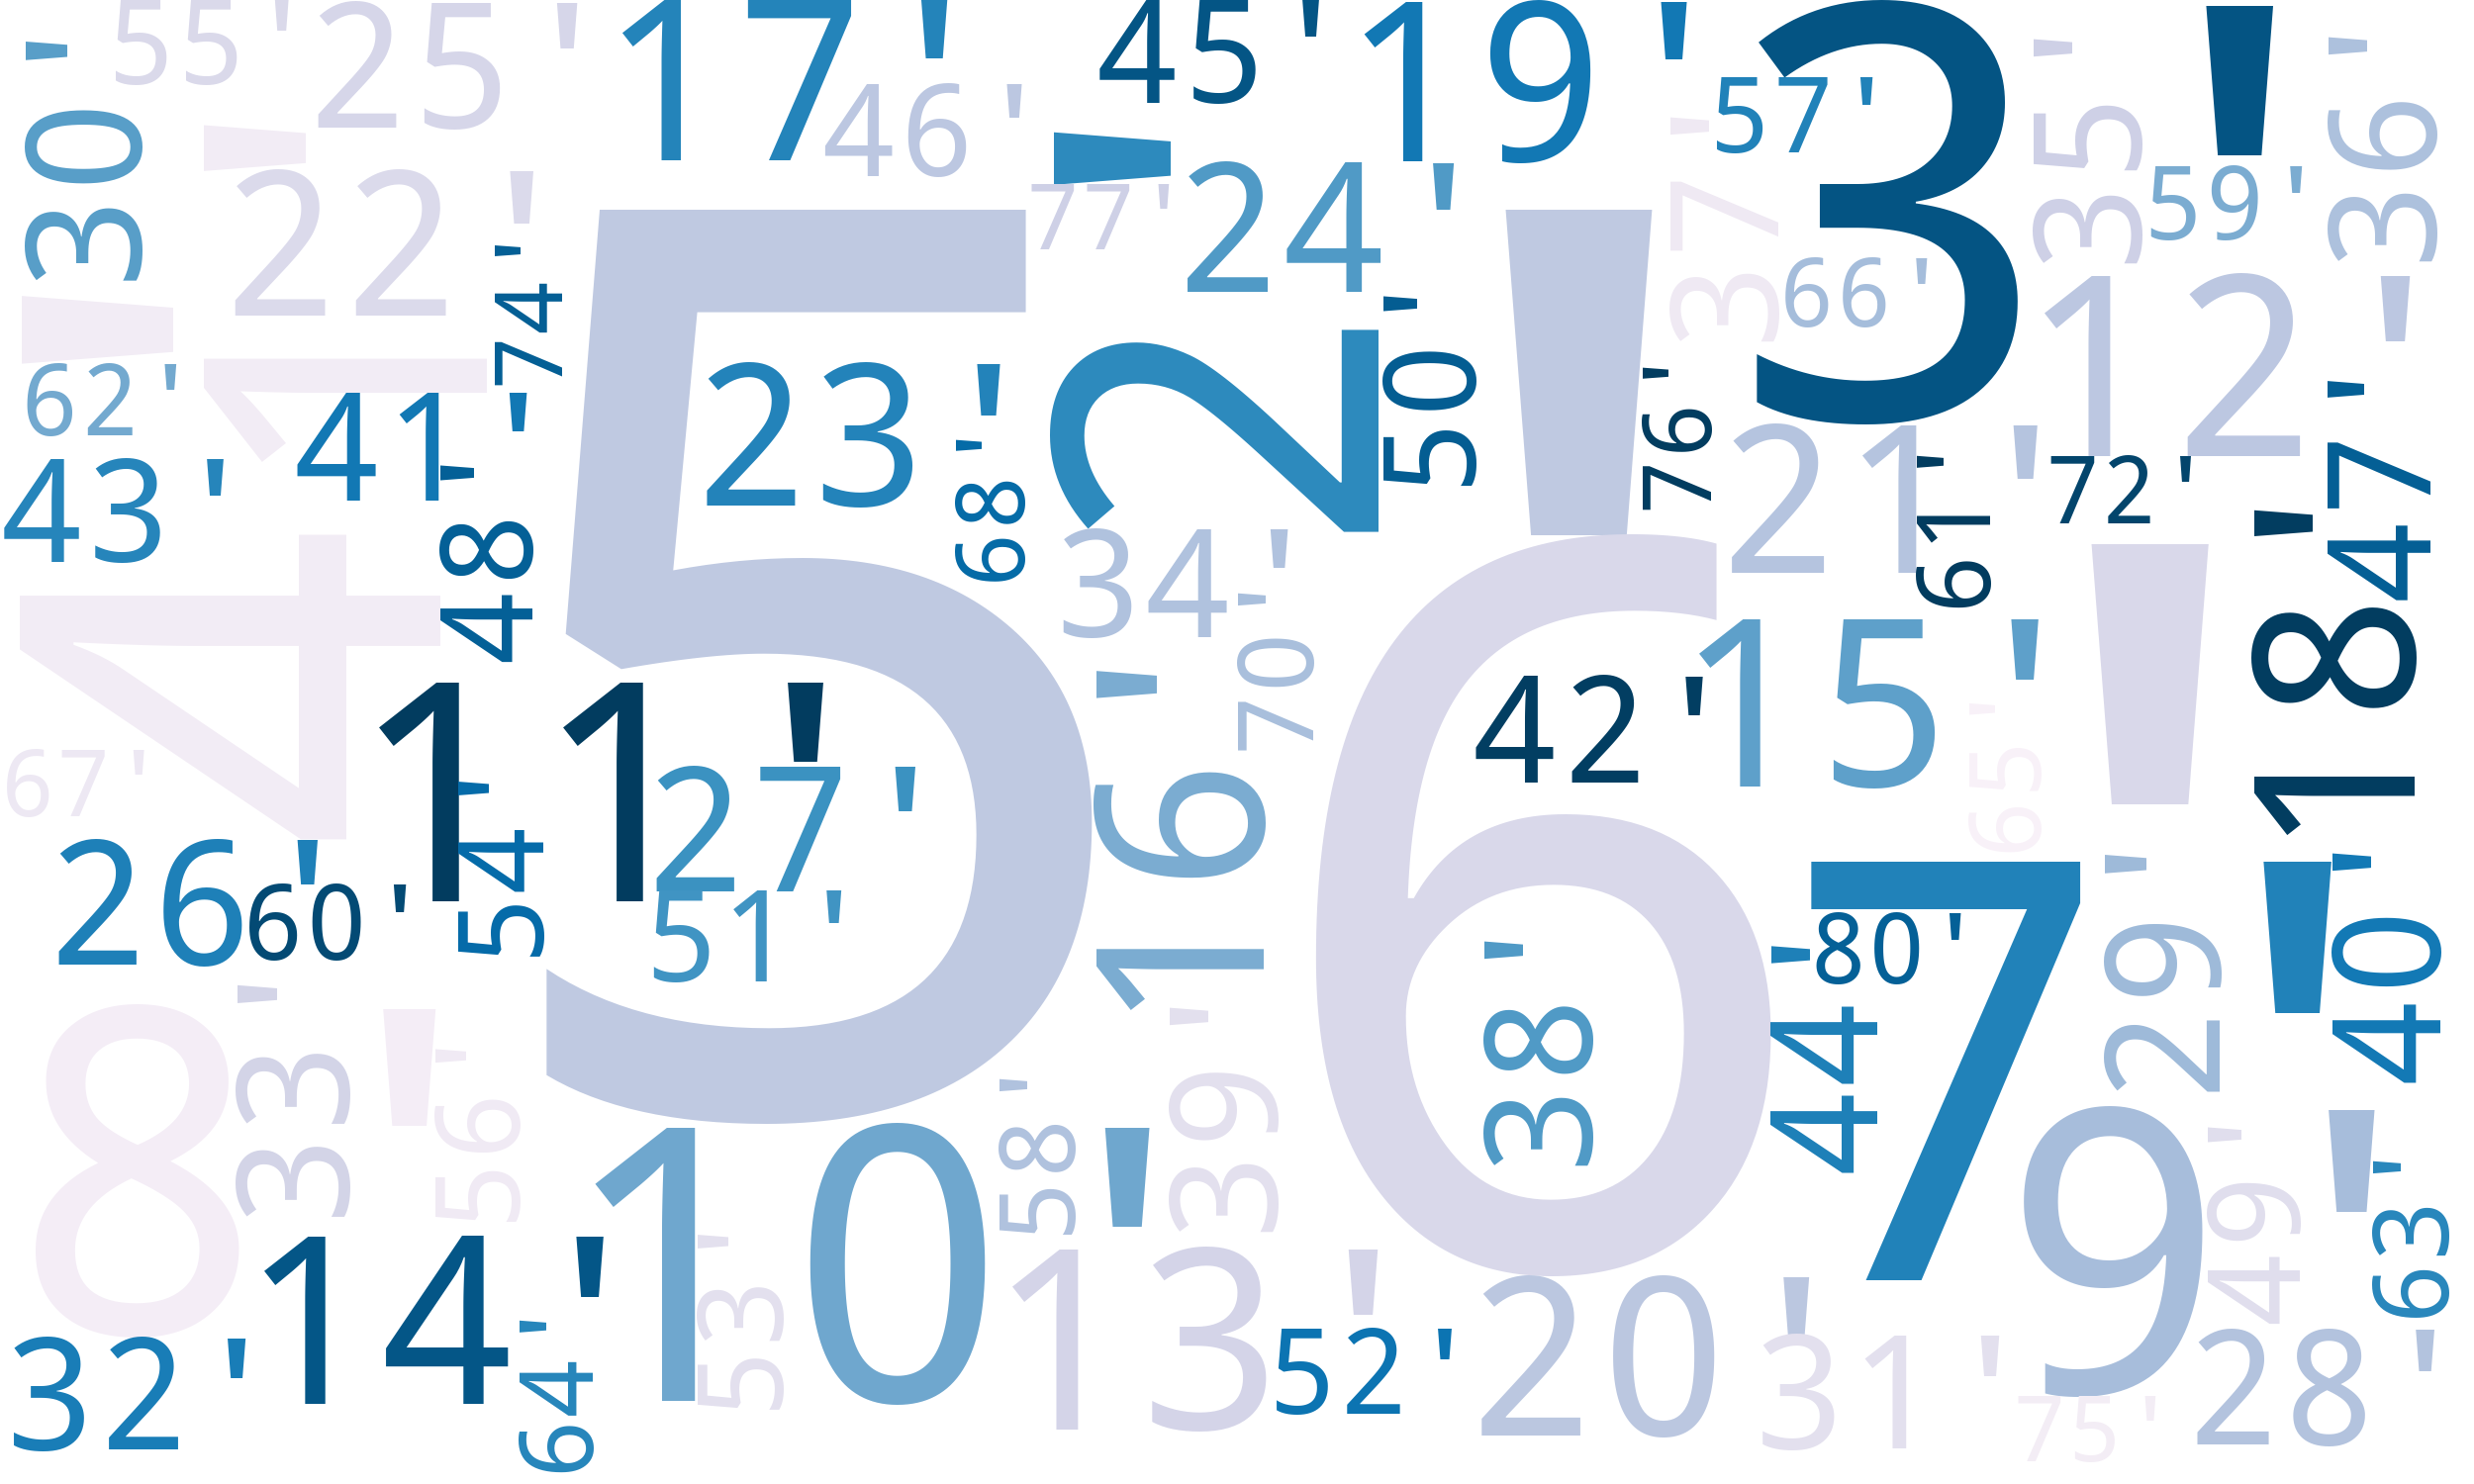

In [6]:
from wordcloud import WordCloud
df = train.groupby("order_id").count()['product_id'].value_counts()
df = df.reset_index().sort_values(by='product_id',ascending = False)
df['index'] = df['index'].astype(str)
df = df.to_records(index=False)

wordcloud = WordCloud (
                    background_color = 'white',
                    width = 2500,
                    height = 1500,margin=0,colormap = 'PuBu'
                        ).generate(str(df))
items_count = px.imshow(wordcloud,width = 1000)
items_count.update_layout(
    title={
        'text': "<b>What Is The Most Frequent Items Count Per Order?</b>",
        'y':0.98,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

items_count.update_xaxes(visible = False)
items_count.update_yaxes(visible = False)
items_count.show()

In [7]:
def Get_Best_Seller(filters):
    if filters == None :
        df = train.groupby("product_id")["reordered"].count().reset_index()
        df = pd.merge(df, products[['product_id', 'product_name']], how='left', on=['product_id'])
    else:
        df = train.groupby("product_id")["reordered"].count().reset_index()
        grouped = pd.merge(products[['product_id', 'product_name','department_id']],depts, how='left', on=['department_id'])
        df = pd.merge(df, grouped[['product_id', 'product_name','department']], how='left', on=['product_id'])
        df = df[df['department'] == filters]
    
    df.sort_values(by='reordered', ascending=False, inplace=True)
    df = df.head(10)
    df.sort_values(by='reordered', ascending=True, inplace=True)    
    best_seller = px.bar(df,x='reordered',y='product_name',labels={"reordered":"Count", "product_name":"Product Name"},
                         color_continuous_scale = color_scale,color= 'reordered',height=300)
    best_seller.update_layout(
        title={
            'text': "<b>What Are The Best Sellers?</b>",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'})
    return best_seller
        
Get_Best_Seller('household').show()

In [8]:
def Get_often_ordered(filters):    
    if filters == None:
        df = train.groupby("product_id")["reordered"].sum().reset_index()
        df = pd.merge(df, products[['product_id', 'product_name']], how='left', on=['product_id'])
    else:
        df = train.groupby("product_id")["reordered"].sum().reset_index()
        grouped = pd.merge(products[['product_id', 'product_name','department_id']],depts, how='left', on=['department_id'])
        df = pd.merge(df, grouped[['product_id', 'product_name','department']], how='left', on=['product_id'])
        df = df[df['department'] == filters]
    df['count'] = train.groupby("product_id")["reordered"].count().reset_index()["reordered"]
    df['mean'] = df['reordered']/df['count']
    df = df[df['count']>40]
    df.sort_values(by='mean', ascending=False, inplace=True)
    df = df.head(10)
    df.sort_values(by='mean', ascending=True, inplace=True)    
    often_reordered = px.bar(df,x='mean',y='product_name',labels={"mean":"Reordered Ratio", "product_name":"Product Name"},
                             color_continuous_scale = color_scale,color= 'mean',height=300)
    often_reordered.update_layout(
        title={
            'text': "<b>Which Item Is Most Often Reordered?</b> ",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'})
    return often_reordered
        
Get_often_ordered('household').show()
    
    

In [9]:
def Get_first_inCart(filters):
    if filters == None:
        df = train[train['add_to_cart_order']==1].groupby('product_id').count().reset_index()
        df = pd.merge(df, products[['product_id', 'product_name']], how='left', on=['product_id'])
    else:
        df = train[train['add_to_cart_order']==1].groupby('product_id').count().reset_index()
        grouped = pd.merge(products[['product_id', 'product_name','department_id']],depts, how='left', on=['department_id'])
        df = pd.merge(df, grouped[['product_id', 'product_name','department']], how='left', on=['product_id'])
        df = df[df['department'] == filters]
    count = train.groupby('product_id').count().reset_index()
    df = pd.merge(df, count[['product_id', 'reordered']], how='left', on=['product_id'])
    df = df[df['reordered_x']>10]
    df['mean'] = df['reordered_x']/df['reordered_y']
    df = df.sort_values(by='mean',ascending=False).head(10)
    df.sort_values(by='mean', ascending=True, inplace=True) 
    
    first_in_cart = px.bar(df,x='mean',y='product_name',labels={"mean":"First in Cart Ratio", "product_name":"Product Name"},
                           color_continuous_scale = color_scale,color= 'mean',height=300)
    first_in_cart.update_layout(
        title={
            'text': "<b>Which Item Do People Put into the Cart First?</b>",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'})
    return first_in_cart

Get_first_inCart('household').show()


In [10]:
my_css_link = 'https://codepen.io/chriddyp/pen/bWLwgP.css'

In [11]:
app = dash.Dash(external_stylesheets = [my_css_link])
style =  {'margin':'0px'}
dropDown = dcc.Dropdown(id = "drop",options=[{'label':dept,'value':dept} for dept in depts.department],value = None)

app.layout = html.Div([
        html.Div([html.Br(), html.H1('Hyper Market Analysis')],style={'height':'100px','textAlign':'center','background-color': '#B6CEC7'}),
        html.Div([
            html.Div([
                html.Div([html.H5('Department'),dropDown],style={'height':'90px'}),
                html.Div([dcc.Graph(figure = {},id = 'best_seller')]),
                html.Div([dcc.Graph(figure = {},id = 'often_reordered')]),
                html.Div([dcc.Graph(figure = {},id = 'first_in_cart')])
            ],style = style,className = 'four columns'),
            html.Div([
                html.Div(style={'height':'85px'}),
                html.Div([dcc.Graph(figure = items_count)]),
                html.Div([dcc.Graph(figure = reorder_probability)],style={'height':'100px'})
            ],style = style,className = 'four columns'),
            html.Div([dcc.Graph(figure = treemap)],style = style,className = 'four columns')
        ],className = 'row')])


In [12]:
@app.callback(
    Output(component_id = 'best_seller',component_property = 'figure' ),
    Input(component_id = 'drop',component_property = 'value' )
)
def update_g1(val):
    return Get_Best_Seller(val)

@app.callback(
    Output(component_id = 'often_reordered',component_property = 'figure' ),
    Input(component_id = 'drop',component_property = 'value' )
)
def update_g1(val):
    return Get_often_ordered(val)

@app.callback(
    Output(component_id = 'first_in_cart',component_property = 'figure' ),
    Input(component_id = 'drop',component_property = 'value' )
)
def update_g1(val):
    return Get_first_inCart(val)


In [ ]:
app.run_server()

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
